In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-04 10:45:58.195194: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 10:45:58.203593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749030358.213061 1532527 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749030358.215747 1532527 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749030358.223384 1532527 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [19]:

# Define paths for the dataset (remember to unzip the dataset first!)
train_csv_path = 'data/Train.csv'  # Path to the training labels CSV file
test_csv_path = 'data/Test.csv'    # Path to the test image IDs CSV file
train_data_path = 'data/train_data/train_data'  # Folder where .npy train files are located
test_data_path = 'data/test_data/train_data'    # Folder where .npy test files are located

# Load Train.csv and inspect the data
train_df = pd.read_csv(train_csv_path)
print("Train.csv:")
print(train_df.head())

print(train_df.label.value_counts())

Train.csv:
          ID  label
0  ID_HUD1ST      1
1  ID_KGE2HY      1
2  ID_VHV9BL      1
3  ID_ZT0VEJ      0
4  ID_5NFXVY      0
label
0    5892
1    1255
Name: count, dtype: int64


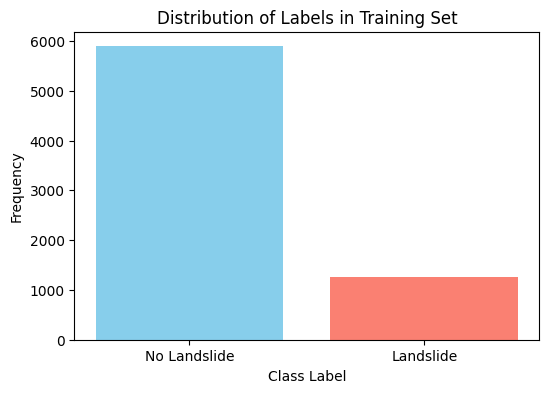

In [20]:
# Check distribution of labels
label_counts = train_df['label'].value_counts()
labels = ['No Landslide', 'Landslide']  # Map the labels 0 and 1 to descriptive names

plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()

In [44]:
import torch

In [45]:
torch.cuda.is_available()

True

In [29]:
#os.listdir(train_data_path)

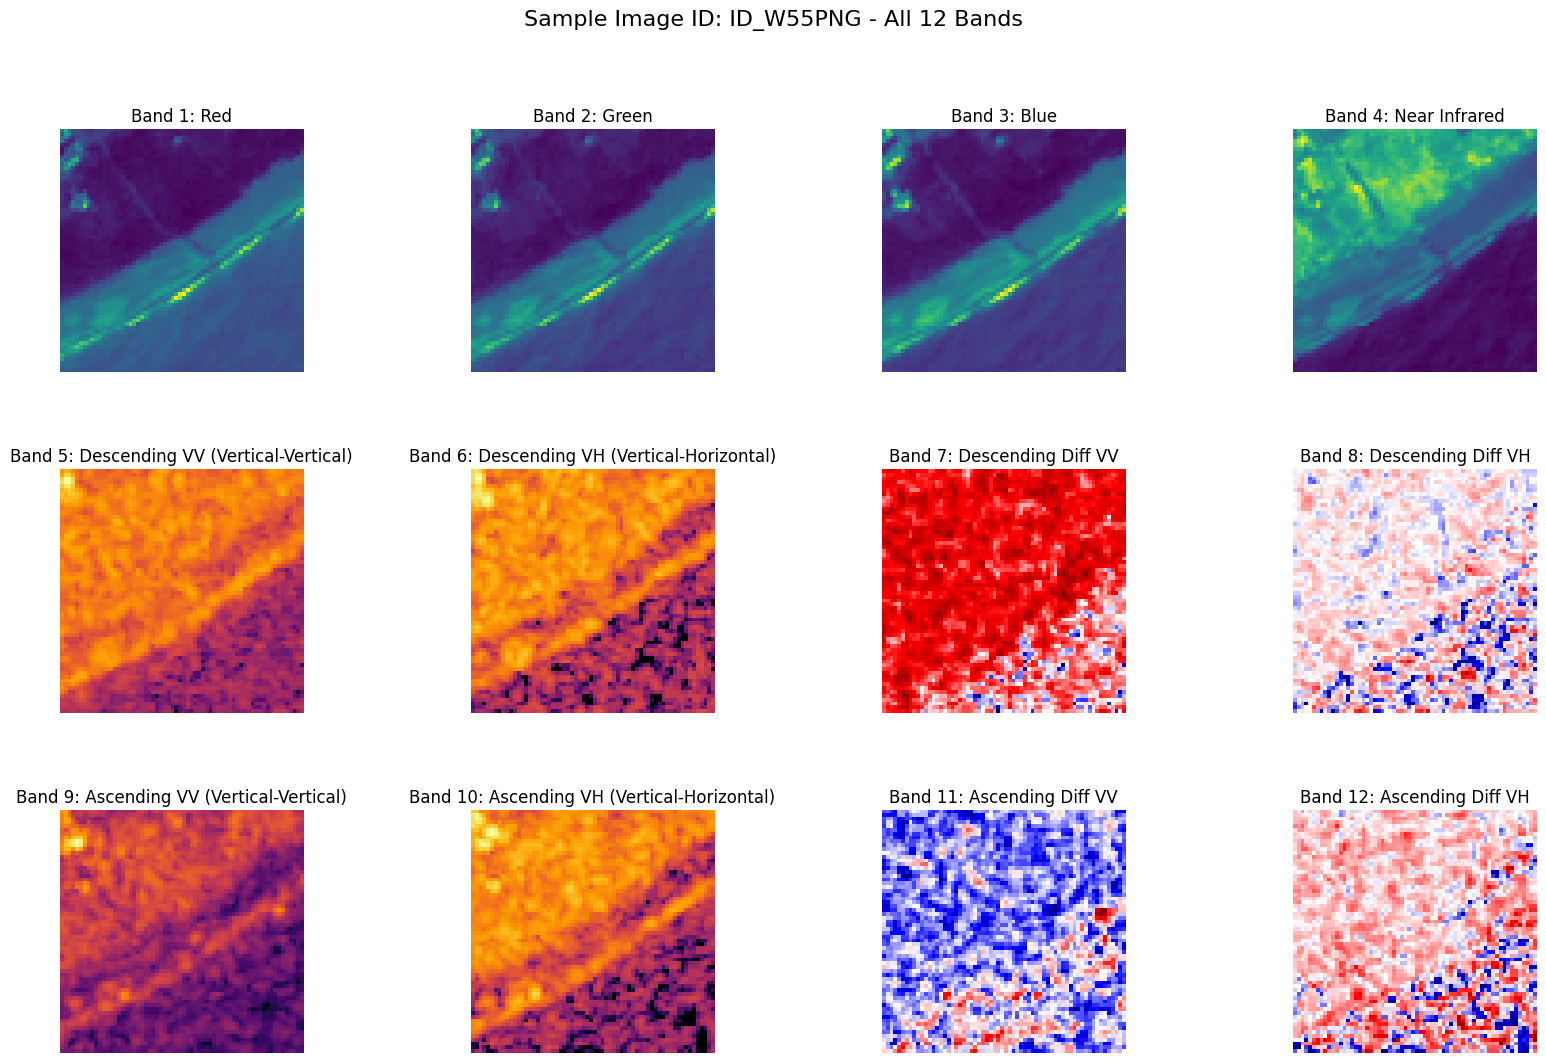

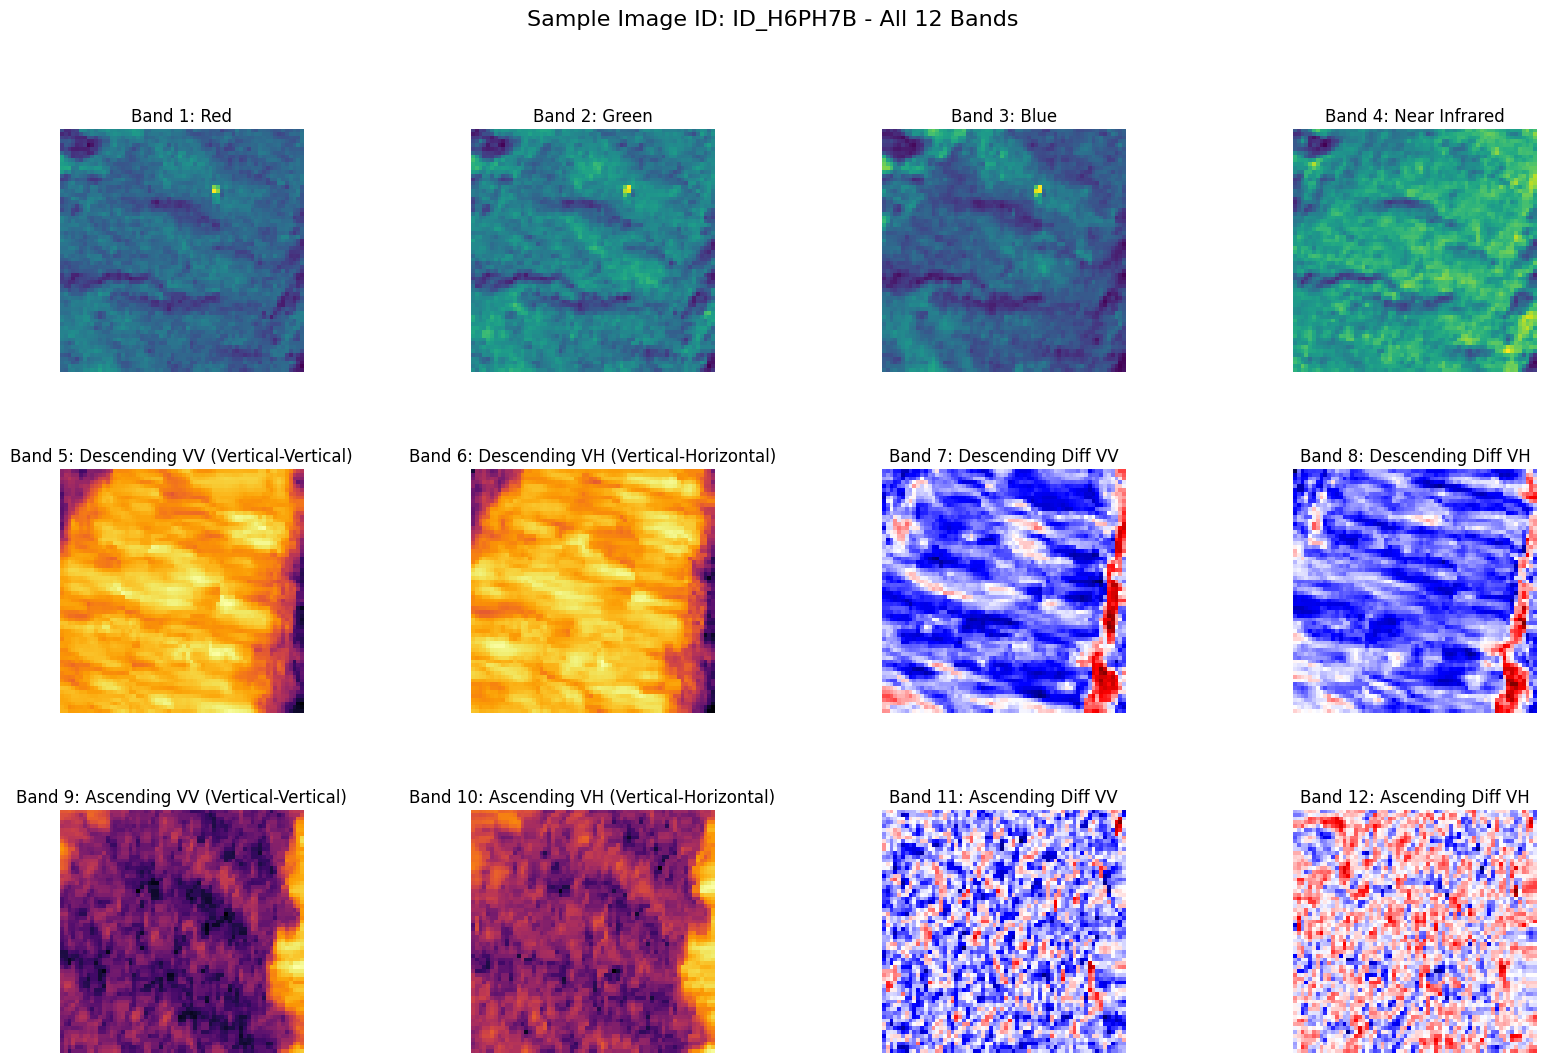

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to load and normalize .npy images
def load_and_normalize_npy_image(image_id, folder_path):
    """Loads a .npy file, normalizes each band, and returns the normalized image."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path)

    # Normalize each band to 0-1 range
    img_normalized = (img - img.min(axis=(0, 1))) / (img.max(axis=(0, 1)) - img.min(axis=(0, 1)) + 1e-5)
    return img_normalized

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Define colormaps for each band based on type
band_cmaps = [
    "viridis", "viridis", "viridis", "viridis",       # Bands 1-4: Visible + NIR
    "inferno", "inferno",                             # Bands 5-6: Descending radar intensity
    "seismic", "seismic",                             # Bands 7-8: Descending radar difference
    "inferno", "inferno",                             # Bands 9-10: Ascending radar intensity
    "seismic", "seismic"                              # Bands 11-12: Ascending radar difference
]

# Displaying a few example images with all 12 bands
example_ids = train_df['ID'].sample(2).values  # Randomly select 2 image IDs for illustration

for image_id in example_ids:
    img_normalized = load_and_normalize_npy_image(image_id, train_data_path)

    # Plot all 12 bands in a 3x4 grid
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # 3 rows, 4 columns for 12 plots
    fig.suptitle(f"Sample Image ID: {image_id} - All 12 Bands", fontsize=16)

    # Display each of the 12 bands with descriptions and appropriate colormap
    for band in range(12):
        row = band // 4  # Calculate row index (0, 1, or 2)
        col = band % 4   # Calculate column index (0 to 3)
        axes[row, col].imshow(img_normalized[:, :, band], cmap=band_cmaps[band])
        axes[row, col].set_title(f"Band {band + 1}: {band_descriptions[band]}")
        axes[row, col].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between plots
    plt.show()


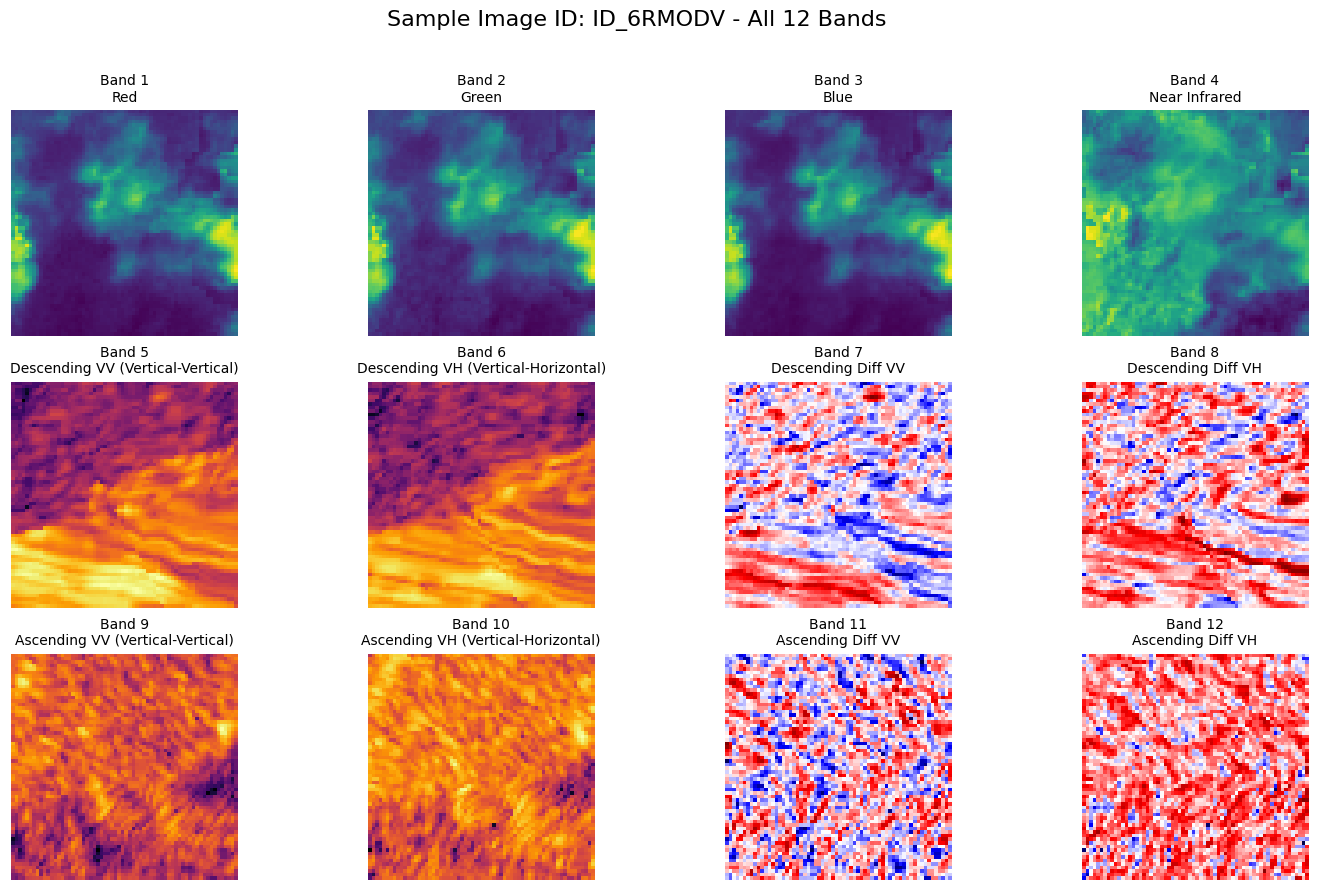

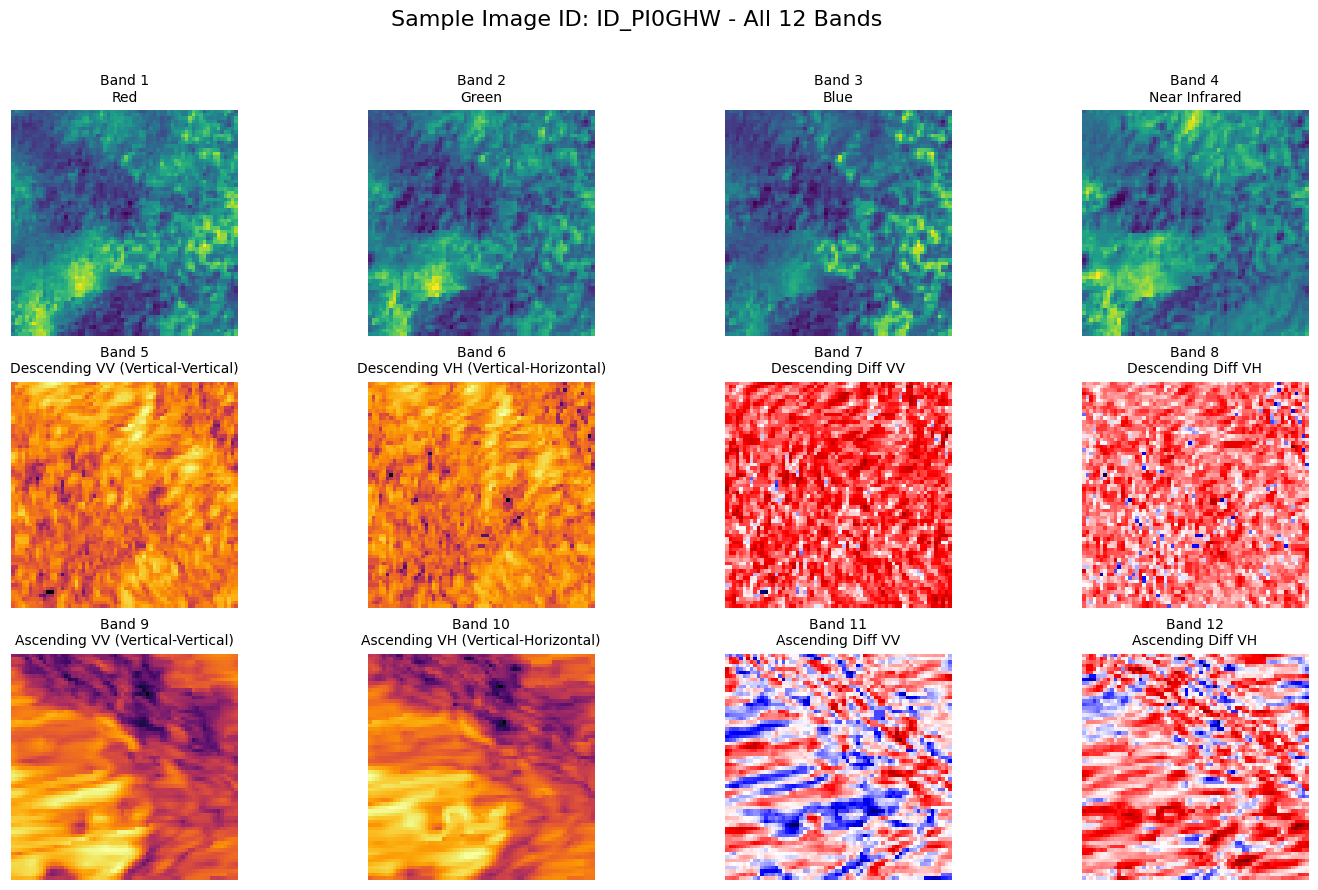

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to load and normalize .npy images
def load_and_normalize_npy_image(image_id, folder_path):
    """Loads a .npy file, normalizes each band, and returns the normalized image."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path)

    # Normalize each band to 0–1 range
    img_normalized = (img - img.min(axis=(0, 1))) / (img.max(axis=(0, 1)) - img.min(axis=(0, 1)) + 1e-5)
    return img_normalized

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Colormap suggestions
band_cmaps = [
    "viridis", "viridis", "viridis", "viridis",       # Bands 1–4: Optical/NIR
    "inferno", "inferno",                             # Bands 5–6: Descending radar
    "seismic", "seismic",                             # Bands 7–8: Descending diff
    "inferno", "inferno",                             # Bands 9–10: Ascending radar
    "seismic", "seismic"                              # Bands 11–12: Ascending diff
]

# Display a few example images with all 12 bands
example_ids = train_df['ID'].sample(2).values  # Randomly select 2 image IDs

for image_id in example_ids:
    img_normalized = load_and_normalize_npy_image(image_id, train_data_path)

    # Plot all 12 bands in a 3×4 grid
    fig, axes = plt.subplots(3, 4, figsize=(18, 10))  # Slightly smaller for tighter fit
    fig.suptitle(f"Sample Image ID: {image_id} - All 12 Bands", fontsize=16)

    for band in range(12):
        row, col = divmod(band, 4)
        ax = axes[row, col]
        ax.imshow(img_normalized[:, :, band], cmap=band_cmaps[band])
        ax.set_title(f"Band {band + 1}\n{band_descriptions[band]}", fontsize=10)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Tighter spacing
    plt.show()


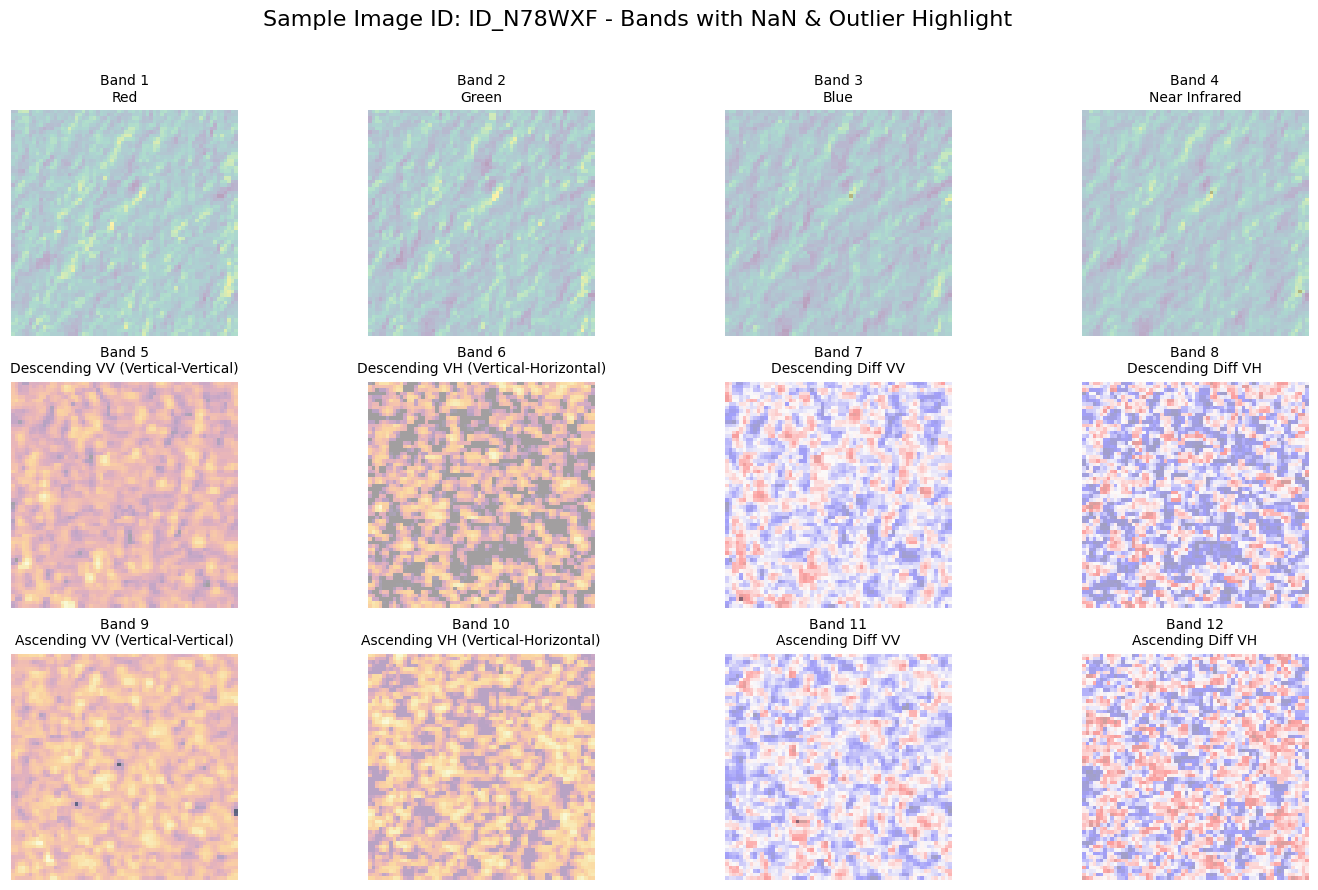

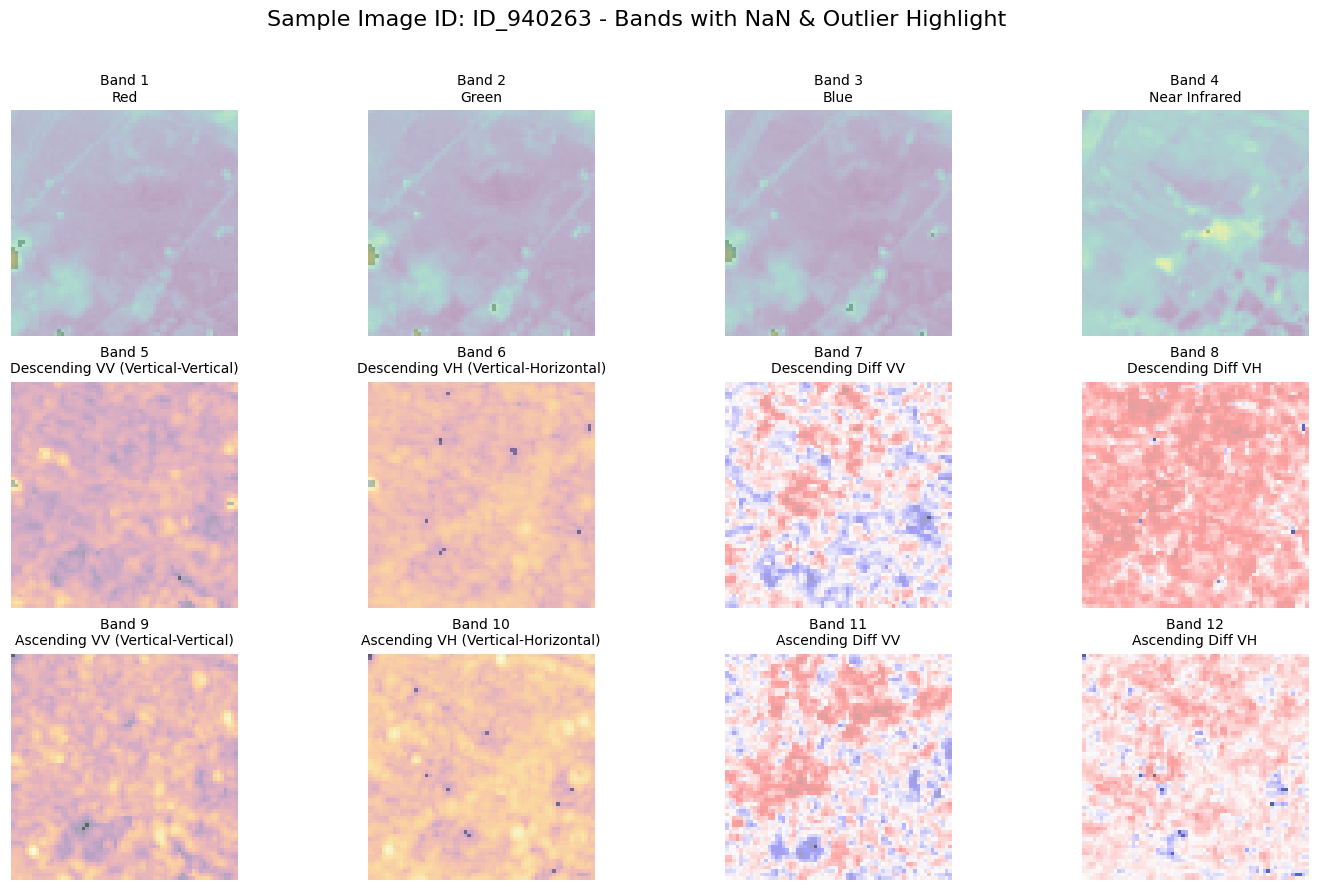

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_and_normalize_npy_image(image_id, folder_path):
    """Loads a .npy file, normalizes each band, and returns the normalized image."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path)

    # Save NaN mask before normalization
    nan_mask = np.isnan(img)

    # Normalize each band to 0–1, handling NaNs
    img_min = np.nanmin(img, axis=(0, 1), keepdims=True)
    img_max = np.nanmax(img, axis=(0, 1), keepdims=True)
    img_normalized = (img - img_min) / (img_max - img_min + 1e-5)

    return img_normalized, nan_mask

# Optional: mask extreme outliers (> Z threshold)
def get_outlier_mask(img, z_thresh=4):
    mean = np.nanmean(img, axis=(0, 1), keepdims=True)
    std = np.nanstd(img, axis=(0, 1), keepdims=True)
    z_scores = np.abs((img - mean) / (std + 1e-5))
    return z_scores > z_thresh

# Descriptions and colormaps
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]
band_cmaps = [
    "viridis", "viridis", "viridis", "viridis",
    "inferno", "inferno",
    "seismic", "seismic",
    "inferno", "inferno",
    "seismic", "seismic"
]

# Example visualization
example_ids = train_df['ID'].sample(2).values

for image_id in example_ids:
    img_normalized, nan_mask = load_and_normalize_npy_image(image_id, train_data_path)
    outlier_mask = get_outlier_mask(img_normalized)  # optional

    fig, axes = plt.subplots(3, 4, figsize=(18, 10))
    fig.suptitle(f"Sample Image ID: {image_id} - Bands with NaN & Outlier Highlight", fontsize=16)

    for band in range(12):
        row, col = divmod(band, 4)
        ax = axes[row, col]

        # Main image
        ax.imshow(img_normalized[:, :, band], cmap=band_cmaps[band])

        # NaN mask (red overlay)
        ax.imshow(nan_mask[:, :, band], cmap='Reds', alpha=0.5)

        # Optional: Outlier mask (blue overlay)
        ax.imshow(outlier_mask[:, :, band], cmap='Blues', alpha=0.3)

        ax.set_title(f"Band {band + 1}\n{band_descriptions[band]}", fontsize=10)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()


In [34]:
# does the putlier match with the event?#data driven has one of these today

In [38]:
folder_path = train_data_path

X = np.array([load_and_normalize_npy_image(image_id, folder_path)[0] for image_id in train_df['ID']])
y = train_df['label'].values

# Perform a stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42, stratify=y)

# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define a simple generator for validation (no augmentation)
val_datagen = ImageDataGenerator()

# Define batch size
batch_size = 32

# Create generators using .flow()
train_ds = train_datagen.flow(
    X_train, y_train, batch_size=batch_size, seed=42, shuffle=True
)

val_ds = val_datagen.flow(
    X_val, y_val, batch_size=batch_size, seed=42, shuffle=True
)


/home/tdx/miniconda3/envs/geodl/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5717, 64, 64, 12) (12 channels).
  warnings.warn(
/home/tdx/miniconda3/envs/geodl/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1430, 64, 64, 12) (12 channels).
  warnings.warn(


In [39]:
X_batch, y_batch = train_ds[0]

In [40]:
X_batch.shape, y_batch.shape

((32, 64, 64, 12), (32,))

In [41]:
X_val_batch, y_val_batch = val_ds[0]

In [42]:
X_val_batch.shape, y_val_batch.shape

((32, 64, 64, 12), (32,))

In [1]:
# Precision metric
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall metric
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# F1 Score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Define the Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Parameters:
        gamma (float): Focusing parameter; typically set to 2.0.
        alpha (float): Balancing factor; typically set to 0.25.

    Returns:
        Binary Focal Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate focal loss
        fl = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)

    return focal_loss_fixed

# Define the CNN model
model = Sequential([
    # First convolutional block
    Input(shape=X_batch.shape[1:]),
    Conv2D(32, (3, 3), activation='relu', data_format='channels_last'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth convolutional block for deeper feature extraction
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Flatten and add dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with Focal Loss and additional metrics
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy', precision_m, recall_m, f1_m]  # Additional metrics
)

# Display the model summary
model.summary()

NameError: name 'Sequential' is not defined